In [ ]:
%pip install pandas numpy tensorflow scikit-learn matplotlib seaborn

Note: you may need to restart the kernel to use updated packages.


In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Input, Dropout, Embedding, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix, classification_report, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv("modifiedDataset_WithDIM.csv")

numerical_cols = ["No_of_Attributes", "No_of_Records"]
scaler = StandardScaler()
df[numerical_cols] = scaler.fit_transform(df[numerical_cols])

visualization_classes = {
    1: "Histogram",
    2: "Pie Chart",
    3: "Map",
    4: "Treemap",
    5: "Parallel Coordinates",
    6: "Scatter Plot",
    7: "Linked Graph",
    8: "Line Chart"
}
df["Chart_Type"] = df["Chart_Type"].map(visualization_classes)

expertise_mapping = {
    0: "Non-Expert",
    1: "Expert"
}
df["Target Audience"] = df["Target Audience"].map(expertise_mapping)

print("Mean values:", scaler.mean_)
print("Standard deviation values:", scaler.scale_)

Mean values: [  7.295  498.4625]
Standard deviation values: [ 14.8200194  974.81305315]


In [4]:
df

,Data_Dimensions,No_of_Attributes,No_of_Records,Primary_Variable (Data Type),Task (Purpose),Target Audience,Chart_Type
0,1D,-0.424763,-0.490825,continous,distribution,Non-Expert,Histogram
1,ND,0.857286,-0.306174,categorical,relationship,Expert,Parallel Coordinates
2,1D,-0.424763,-0.470308,ordinal,trends,Non-Expert,Line Chart
3,1D,-0.424763,-0.506212,continous,distribution,Non-Expert,Histogram
4,1D,-0.424763,-0.505187,continous,distribution,Non-Expert,Histogram
...,...,...,...,...,...,...,...
395,ND,2.881575,-0.203590,continous,relationship,Expert,Parallel Coordinates
396,Hierarchical,0.857286,2.053253,ordinal,comparison,Expert,Treemap
397,1D,-0.424763,-0.475437,ordinal,distribution,Non-Expert,Line Chart
398,1D,-0.424763,-0.465179,continous,distribution,Non-Expert,Histogram


In [ ]:
df = pd.get_dummies(df, columns=['Data_Dimensions','Primary_Variable (Data Type)', 'Task (Purpose)', 'Target Audience'], drop_first=True, dtype=int)
encoded_target = pd.get_dummies(df["Chart_Type"], dtype=int)
df = df.drop(columns=["Chart_Type"])
X = df
Y = encoded_target

In [ ]:
print(X.columns)

Index(['No_of_Attributes', 'No_of_Records', 'Data_Dimensions_2D',
       'Data_Dimensions_Hierarchical', 'Data_Dimensions_ND',
       'Primary_Variable (Data Type)_continous',
       'Primary_Variable (Data Type)_geographical',
       'Primary_Variable (Data Type)_ordinal', 'Task (Purpose)_distribution',
       'Task (Purpose)_relationship', 'Task (Purpose)_trends',
       'Target Audience_Non-Expert'],
      dtype='object')


In [ ]:
import os
kf = KFold(n_splits=10, shuffle=True, random_state=42)
accuracies = []
r2_scores = []
conf_matrix = np.zeros((Y.shape[1], Y.shape[1]))  # Initialize confusion matrix

for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    Y_train, Y_test = Y.iloc[train_index], Y.iloc[test_index]
    model = Sequential([
        Input(shape=(X_train.shape[1],)), 
        Dense(16, activation='relu'), 
        Dropout(0.2), 
        Dense(12, activation='relu'),  
        Dense(Y.shape[1], activation='softmax') 
    ])
    optimizer = Adam(learning_rate=0.005)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy', 'mse'])
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

    history = model.fit(X_train, Y_train, epochs=500, batch_size=10, verbose=1, validation_data=(X_test, Y_test), callbacks=[early_stopping])
    loss, accuracy, mse = model.evaluate(X_test, Y_test)
    accuracies.append(accuracy)

    y_pred = model.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true_classes = np.argmax(Y_test.values, axis=1)
    fold_conf_matrix = confusion_matrix(y_true_classes, y_pred_classes, labels=range(Y.shape[1]))
    conf_matrix += fold_conf_matrix

    r2 = r2_score(y_true_classes, y_pred_classes)
    r2_scores.append(r2)

save_dir = "/workspaces/codespaces-models/visiobot-project/visiobot-backend/saved_models"
os.makedirs(save_dir, exist_ok=True)
model_path = os.path.join(save_dir, "visiobot_model.keras")
model.save(model_path)
print("Model saved successfully!")

final_accuracy = np.mean(accuracies) * 100
final_r2 = np.mean(r2_scores)
print(f"Final Mean Accuracy: {final_accuracy:.2f}%")
print(f"Final Mean R² Score: {final_r2:.4f}")

Epoch 1/500


36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.2376 - loss: 2.0597 - mse: 0.1083 - val_accuracy: 0.5750 - val_loss: 1.6668 - val_mse: 0.0906
Epoch 2/500
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5344 - loss: 1.4922 - mse: 0.0821 - val_accuracy: 0.6250 - val_loss: 1.1488 - val_mse: 0.0616
Epoch 3/500
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6411 - loss: 1.0603 - mse: 0.0591 - val_accuracy: 0.7750 - val_loss: 0.8345 - val_mse: 0.0472
Epoch 4/500
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8128 - loss: 0.6704 - mse: 0.0392 - val_accuracy: 0.8000 - val_loss: 0.5524 - val_mse: 0.0331
Epoch 5/500
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8624 - loss: 0.5038 - mse: 0.0275 - val_accuracy: 0.8500 - val_loss: 0.3462 - val_mse: 0.0208
Epoch 6/500
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8598 - loss: 0.4167 - mse: 0.0260 - val_accuracy: 0.9250 - val_loss: 0.2660 - val_mse: 0.0151
Epoch 7/500
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accur

In [12]:
model.summary()

Model: "sequential_49"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_147 (Dense)               │ (None, 16)             │           208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_49 (Dropout)            │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_148 (Dense)               │ (None, 12)             │           204 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_149 (Dense)               │ (None, 8)              │           104 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,550 (6.06 KB)

 Trainable params: 516 (2.02 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,034 (4.04 KB)

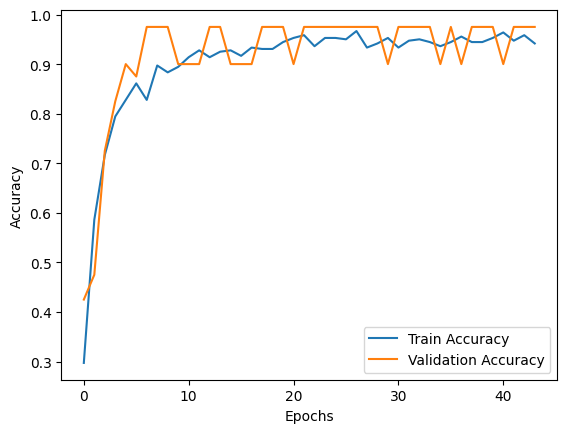

In [ ]:
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

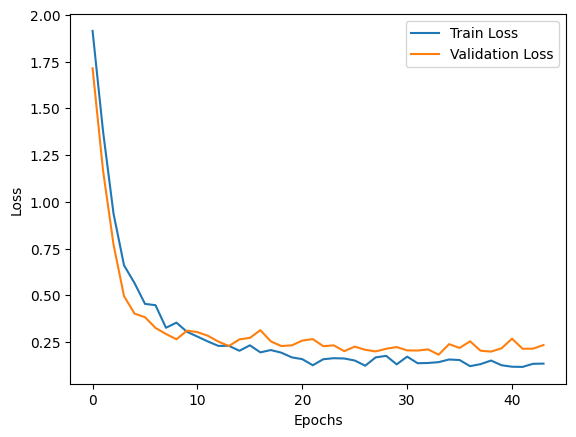

In [14]:
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

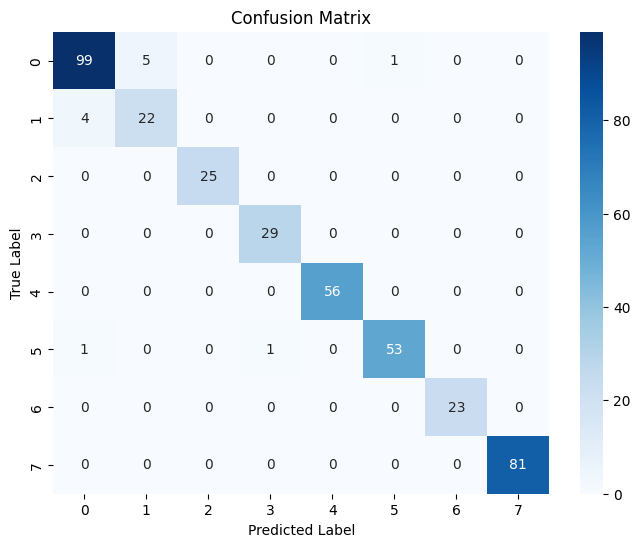

In [ ]:
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix.astype(int), annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
report = classification_report(y_true_classes, y_pred_classes, target_names=list(visualization_classes.values()), labels=range(8))
print("Classification Report:\n", report)

Classification Report:
                       precision    recall  f1-score   support

           Histogram       0.92      1.00      0.96        11
           Pie Chart       1.00      1.00      1.00         4
                 Map       0.00      0.00      0.00         0
             Treemap       1.00      1.00      1.00         3
Parallel Coordinates       1.00      1.00      1.00         5
        Scatter Plot       1.00      0.88      0.93         8
        Linked Graph       1.00      1.00      1.00         6
          Line Chart       1.00      1.00      1.00         3

            accuracy                           0.97        40
           macro avg       0.86      0.86      0.86        40
        weighted avg       0.98      0.97      0.97        40



/usr/local/python/current/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/python/current/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/python/current/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/

In [ ]:
TP = np.diag(conf_matrix)
FP = np.sum(conf_matrix, axis=0) - TP
FN = np.sum(conf_matrix, axis=1) - TP
TN = np.sum(conf_matrix) - (TP + FP + FN)

TPR = np.sum(TP) / (np.sum(TP) + np.sum(FN))  # Sensitivity / Recall
TNR = np.sum(TN) / (np.sum(TN) + np.sum(FP))  # Specificity
FPR = np.sum(FP) / (np.sum(FP) + np.sum(TN))  # False Positive Rate
FNR = np.sum(FN) / (np.sum(FN) + np.sum(TP))  # False Negative Rate
Precision = np.sum(TP) / (np.sum(TP) + np.sum(FP))  # Precision Calculation
F1 = 2 * (Precision * TPR) / (Precision + TPR)  # F1 Score Calculation

print(f"True Positive Rate (TPR / Sensitivity): {TPR:.4f}")
print(f"True Negative Rate (TNR / Specificity): {TNR:.4f}")
print(f"False Positive Rate (FPR): {FPR:.4f}")
print(f"False Negative Rate (FNR): {FNR:.4f}")
print(f"Precision: {Precision:.4f}")
print(f"F1 Score: {F1:.4f}")

True Positive Rate (TPR / Sensitivity): 0.9700
True Negative Rate (TNR / Specificity): 0.9957
False Positive Rate (FPR): 0.0043
False Negative Rate (FNR): 0.0300
Precision: 0.9700
F1 Score: 0.9700


In [ ]:
try:
    from ucimlrepo import fetch_ucirepo  
except ImportError:
    import os
    os.system("pip install ucimlrepo")
    from ucimlrepo import fetch_ucirepo  

import pandas as pd
abalone = fetch_ucirepo(id=1)  
X = abalone.data.features  
y = abalone.data.targets  
dataset = pd.concat([X, y], axis=1)
csv_filename = "abalone_dataset.csv"
dataset.to_csv(csv_filename, index=False)
print(f"Dataset downloaded and saved as {csv_filename}")

✅ Dataset downloaded and saved as abalone_dataset.csv


In [ ]:
try:
    from ucimlrepo import fetch_ucirepo  
except ImportError:
    import os
    os.system("pip install ucimlrepo")
    from ucimlrepo import fetch_ucirepo  

import pandas as pd
mushroom = fetch_ucirepo(id=73)  
X = mushroom.data.features  
y = mushroom.data.targets  
dataset = pd.concat([X, y], axis=1)
csv_filename = "mushroom_dataset.csv"
dataset.to_csv(csv_filename, index=False)

✅ Dataset downloaded and saved as mushroom_dataset.csv
